In [1]:
# REF: https://arxiv.org/pdf/0704.1317.pdf

# import libraries
import numpy as np
import scipy
from scipy import interpolate


import matplotlib.pyplot as plt

%matplotlib inline

In [212]:
# Create an integer messege vector b

b = np.array([3,6,7,2,5,2])

# create H here n = 6 d = 3 normalize H to get |det(G)| = |det(H)| = 1

H = np.array([[0, -0.8, 0, -0.5, 1, 0],[0.8, 0, 0, 1, 0, -0.5],[0, 0.5, 1, 0, 0.8, 0],[0, 0, -0.5, -0.8, 0, 1],[1, 0, 0, 0, 0.5, 0.8],[0.5, -1, -0.8, 0, 0, 0]])

H_norm = H/np.abs(np.linalg.det(H))**(1/6.)

# Calculate generator matrix G = inv(H) normalize H to get |det(G)| = 1

G = np.linalg.inv(H_norm)

# Calculate codeword x

x = np.dot(G,b)

x = x.reshape(-1,1)

# create noisy codeword y = x + w

mu, sigma = 0, 10 # mean and standard deviation
w = np.random.normal(mu, sigma, x.shape)
y = x + w

# y is user input fingerprint
x_input = np.arange(-200.0,200.1,0.1)



In [3]:
"""
check node --- Q ---> variable node
variable node --- f ---> check node

"""
# Write a funtion that will return check and variable nodes from H matrix

def _ChkandVarNodes(H):
    """Return check and variable nodes of a parity-check matrix H.
    Example:
    
    H = array([[ 0. , -0.8,  0. , -0.5,  1. ,  0. ],
       [ 0.8,  0. ,  0. ,  1. ,  0. , -0.5],
       [ 0. ,  0.5,  1. ,  0. ,  0.8,  0. ],
       [ 0. ,  0. , -0.5, -0.8,  0. ,  1. ],
       [ 1. ,  0. ,  0. ,  0. ,  0.5,  0.8],
       [ 0.5, -1. , -0.8,  0. ,  0. ,  0. ]])
       
    cnode_idx,cnode,vnode_idx,vnode = _ChkandVarNodes(H)
    
    cnode_idx,cnode,vnode_idx,vnode = 
    
    (array([0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 5]),
     array([1, 4, 5, 0, 2, 5, 2, 3, 5, 0, 1, 3, 0, 2, 4, 1, 3, 4]),
     array([0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 5]),
     array([1, 3, 4, 0, 3, 5, 1, 2, 4, 2, 3, 5, 0, 4, 5, 0, 1, 2]))
    
    EACH ROW IS 1 VARIABLE NODE!
    EACH COULMN IS 1 CHECK NODE!
    
    So for check node chk_id is the column index
    """
    if type(H) != scipy.sparse.csr_matrix:
        vnode_indices, vnode_nodes = np.where(H)
        cnode_indices, cnode_nodes = np.where(H.T)
    else:
        vnode_indices, vnode_nodes = scipy.sparse.find(H)[:2]
        cnode_indices, cnode_nodes = scipy.sparse.find(H.T)[:2]
    #chk_histogram = np.bincount(chk_indices)
    #var_histogram = np.bincount(var_indices)

    return cnode_indices, cnode_nodes, vnode_indices, vnode_nodes

In [29]:
# x1, x2, x3, x4,...,xn -> variable node c1,c2,....,cn -> check node
# Initialization from variable to check node

def init_message(x, mat):
    # produces f_k^0(x)
    """
    initial message vector
    
    INPUT
    x (1d array) - input suport vactor
    mat - parity-check matrix.
    
    OUTPUT
    variable node outgoing message
    """
    global sigma
    nvnode,ncnode = mat.shape     
    # initialize outgoing variable messege
    cnode_message = np.zeros(shape = (ncnode,nvnode,len(x)))
    cnode_idx,cnode,_,_ = _ChkandVarNodes(mat)

    cnode_message[tuple([cnode_idx,cnode])] = (np.exp(-(((H[tuple([cnode,cnode_idx])].reshape(-1,1) - x)/sigma)**2)/2.))/(np.sqrt(2*np.pi*sigma**2))
        
    return cnode_message

In [5]:
def extrapolate(x_in,y):
    """
    Given an array, returns the extrapolated function f(x_in)
    y = f(arr)
    
    INPUT
    x_in (1d array) - range of the array
    y (1d array) - array to be interpolated
    
    OUTPUT
    interpolated funtion f(arr)
    """
    f = interpolate.interp1d(x_in, y, fill_value = "extrapolate")
    return f

In [6]:
#Check node will receive a list of varibale node messages.

class CheckNode:
    def __init__(self,H,x):
        """
        initialize CheckNode class

        INPUT
        h (array) - h is the elements of a row from H ex: [0,-0.8,0,-0.5,1,0]
        j (int) - jth check node
        """
        self.H = H
        #self.cnode_id,self.cnode,self.vnode_id,self.vnode = _ChkandVarNodes(H)
        
        # cnode_id --> vnode_ids
        self.vnode_id = [list(H[:,i].nonzero()[0]) for i in range(H.shape[1])] 
        # vnode_id --> cnode_ids
        self.cnode_id = [list(H[i,:].nonzero()[0]) for i in range(H.shape[0])] 
        
        self.nvnode,self.ncnode = H.shape 
        self.x = x
        # initialize outgoing check messege
        self.cnode_message = np.zeros(shape = (self.nvnode,self.ncnode,2*len(self.x) - 1)) # nonzero -1 = 2
        
    def pj(self,chk_idx,var_idx,vnode_message,x_in = None):
        """
        convolve all messages except f_j(x)
        x (array) - input suport vactor
        message (2d matrix) - incoming variable node messages of the form (numvar,len(x))
        chk_idx (int) - check node id
        var_idx (int) - variable node id
        Returns p_j(x)
        """
        
        if x_in is None:
            x_in = self.x
        else:
            assert len(x_in) == len(self.x), "length mismatch!"
            
        assert vnode_message.shape == (self.ncnode, self.nvnode, len(self.x))
        
        # extrapolation should always be on support vector self.x
        vnode_message_func = extrapolate(self.x,vnode_message)
        var_ids =  np.asarray(self.vnode_id[chk_idx])
        p_j = 1
        for i in var_ids[var_ids != var_idx]:
            val = self.H[i,chk_idx]
            p_j = np.convolve(p_j,vnode_message_func(x_in/val)[chk_idx][i].ravel(),mode='full')
        return p_j 
    
    def _conv1node(self,chk_idx,vnode_message,x_in = None):
        """
        convolve all messages for 1 check node
        x (array) - input suport vactor
        message (2d matrix) - incoming variable node messages of the form (numvar,len(x))
        chk_idx (int) - check node id
        Returns p_j(x)
        """

            
        var_message = []
        var_idx =  np.asarray(self.vnode_id[chk_idx])
        for idx in var_idx:
            p_j = 1
            p_j = self.pj(chk_idx,idx,vnode_message,x_in)
            var_message.append(p_j)            
                    
        return var_message     
        
    def conv_all_node(self,vnode_message,x_in = None):
        """
        convolve all checknode messages
        x (array) - input suport vactor
        vnode_message (nd matrix) - incoming variable node messages of the form (numchk,numvar, len(x))
        
        Returns p_j(x)
        """

            
        allmsg = []
        
        for i in range(self.ncnode):
            msg = self._conv1node(i,vnode_message)
            allmsg.append(msg)        
        return allmsg
        

    def stretch_pj(self,chk_idx,var_idx,vnode_message,x_in = None):
        """
        The result is stretched by -h_j
        x_in (array) - input suport vactor
        
        RETURNS p_j(-h_j*x)
        """
        
        if x_in is None:
            x_in = self.x
#         else:
#             assert len(x_in) == len(self.x), "length mismatch!"
            
        h_j = self.H[var_idx,chk_idx]
        p_j = self.pj(chk_idx,var_idx,vnode_message, x_in = -h_j*x_in)
        return p_j
    
    def periodic_extension(self,chk_idx,var_idx,vnode_message,x_in = None):
        """
        The result is extended to a periodic function with period 1/|hj|:
        x (array) - input suport vactor
        
        RETURNS Q_j(x)
        """
        if x_in is None:
            x_in = self.x
            
        h = np.abs(self.H)
        minval = h[np.nonzero(h)].min()
        end = np.rint(self.x.max()*minval) # 100
        i = np.rint(self.x.min()*minval) # -100
        h_j = self.H[var_idx,chk_idx]
        q = 1
        while i < end:
            q += self.stretch_pj(chk_idx,var_idx,vnode_message, x_in = -h_j*x_in - i/h_j)
            i += 1
        return q
    def Q(self,vnode_message):
        """        
        RETURNS Q_j(x) of shape (nvnode,ncnode,8001)
        """
        
        for v_id in range(self.nvnode):
            for c_id in self.cnode_id[v_id]:
                self.cnode_message[v_id,c_id] = self.periodic_extension(c_id,v_id,vnode_message)
            
        return self.cnode_message

In [197]:
def productExceptSelf(nums):
    right_multiply = [0] * len(nums)
    right_multiply[-1]=nums[-1]
    for i in range(1,len(nums)):
        right_multiply[len(nums)-i-1] = right_multiply[len(nums)-i] * nums[len(nums)-i-1]
    output = [0]*len(nums)
    prefix = 1
    current_index = 0
    while current_index < len(output)-1:
        output[current_index] = prefix * right_multiply[current_index+1]
        prefix *= nums[current_index]
        current_index +=1
    output[-1] = prefix
    return output

class VariableNode(CheckNode):
    def __init__(self,H,x):
        super().__init__(H,x)
        self.factor = (np.sqrt(2*np.pi*sigma**2))*init_message(self.x,self.H)
        self.vnode_message = np.zeros(shape = (self.ncnode, self.nvnode, len(self.x)))
    def product(self,cnode_message):
        """
        Returns f_j(x)
        """
        mid = cnode_message.shape[2]//2
        mid_input = len(self.x)//2
        start = mid - mid_input# start of slice
        end = mid + (len(self.x) - mid_input)# end of slice
        for i,cid in enumerate(self.cnode_id):
            temp = np.array(productExceptSelf(cnode_message[i][cid,:]))
            temp = temp[:,start:end]
            #temp = self.factor.transpose(1,0,2)*temp
            self.vnode_message[i][cid,:] = temp
            #print (temp)
        # factor is [chknode][vnode][4001] 

        return self.factor.transpose(1,0,2)*self.vnode_message
    def f(self,cnode_message):
        """
        """
        #normalize
        self.vnode_message = self.product(cnode_message)
        total = np.sum(self.vnode_message, keepdims = True, axis = 2)
        
        res = np.divide(self.vnode_message, total, out=np.zeros_like(self.vnode_message), where=total!=0)
        
        return res.transpose(1,0,2)
    def final(self,cnode_message):
        mid = cnode_message.shape[2]//2
        mid_input = len(self.x)//2
        start = mid - mid_input# start of slice
        for i,cid in enumerate(self.cnode_id):
            temp = np.prod(cnode_message[i][cid,:],axis=0)
            temp = temp[:,start:end]
            self.vnode_message[i][cid,:] = temp

        return self.factor.transpose(1,0,2)*self.vnode_message
        

In [8]:
node = CheckNode(H,x_input)
# node

In [9]:
result = init_message(x_input, H)
#convolution = node.pj(0,5,vnode_message = result,x_in = x_input)
stretch = node.stretch_pj(0,5,vnode_message = result)
#extension = node.periodic_extension(0,5,vnode_message = result)
q = node.Q(vnode_message=result)

In [10]:
q[1,0]

array([1., 1., 1., ..., 1., 1., 1.])

In [11]:
node.cnode_message.shape

(6, 6, 8001)

In [12]:
extension

array([1.02491182, 1.04982338, 1.0747347 , ..., 1.0747347 , 1.04982338,
       1.02491182])

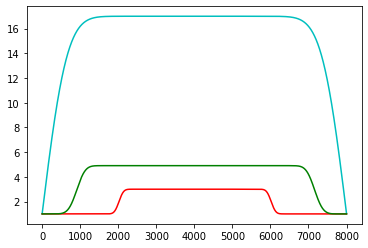

In [13]:
#plt.plot(range(len(stretch)),stretch,'r');
#plt.plot(range(len(stretch)),convolution,'b');
#plt.plot(range(len(stretch)),extension,'g');
plt.plot(range(len(stretch)),q[2,1],'c');
plt.plot(range(len(stretch)),q[2,2],'r');
plt.plot(range(len(stretch)),q[2,4],'g');

## Testing 

In [14]:
node.vnode_id # for each chk node

[[1, 4, 5], [0, 2, 5], [2, 3, 5], [0, 1, 3], [0, 2, 4], [1, 3, 4]]

In [15]:
node.cnode_id # for each var node

[[1, 3, 4], [0, 3, 5], [1, 2, 4], [2, 3, 5], [0, 4, 5], [0, 1, 2]]

In [151]:
vnode = VariableNode(H,x_input)

In [152]:
f = vnode.f(q)

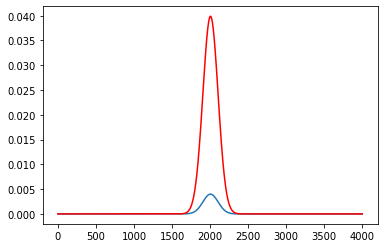

In [159]:
plt.plot(np.arange(4001),f[0][5]);
plt.plot(np.arange(4001),result[0][5],'r');

In [162]:
f.max()-result.max()

-0.03590480523612906

In [ ]:
import timeit

In [ ]:
timeit.timeit('allchknode(x_input,np.arange(6))', 'from __main__ import np, allchknode,x_input', number=1000)

In [198]:
from IPython import display

def visualize(x,y,z):
    plt.plot(x,y,'g',label='before iteration')
    plt.plot(x,z,'r',label = 'after iteration')
    display.clear_output(wait=True)
    plt.legend()
    plt.show();

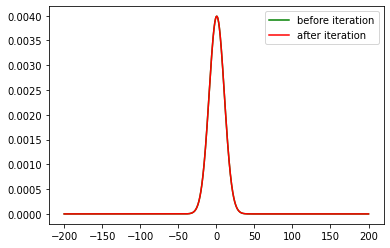

iter3: 0.0


<Figure size 432x288 with 0 Axes>

In [199]:
cnode = CheckNode(H,x_input)
vnode = VariableNode(H,x_input)
res = init_message(x_input, H)
for i in range(4):
    q = cnode.Q(res)
    f = vnode.f(q)
    visualize(x_input,res[0][5],f[0][5])
    print (f'iter{i}:',res[0][5].max()-f[0][5].max())
    res = f
plt.clf();    
    

In [200]:
f_final = vnode.f(q)


In [216]:
x_b = np.argmax(f_final.argmax(axis = 2),axis=1)

In [217]:
np.rint(np.dot(H,x_b))

array([-2.,  3.,  3.,  1.,  6., -2.])

In [213]:
b

array([3, 6, 7, 2, 5, 2])

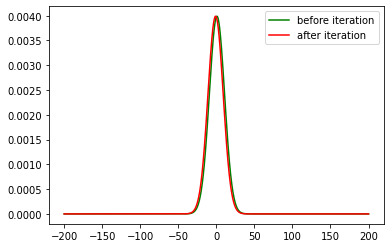

In [232]:
visualize(x_input,f_final[0][1],f_final[1][5])